# TensorFlow for ICT Applications

## Lab session 2: Linear regression

**Content of this lab session:**

1. Installing TensorFlow 2.0.
2. Defining and manipulating tensors (with NumPy interoperability).
3. Automatic differentiation in TensorFlow.
4. A simple linear regression example.

### Installing TensorFlow 2.0

In [1]:
# Need the beta release until official release
!pip install tensorflow==2.0.0-beta0

^C


In [1]:
# Check version
import tensorflow as tf
tf.__version__

'2.0.0-beta0'

In [2]:
# This should be true at startup - otherwise, you are running an old version
tf.executing_eagerly()

True

In [3]:
# Check if a GPU is available on the computer
tf.test.is_gpu_available()

False

### Defining tensors and operating with NumPy

In [4]:
x = tf.constant(2.0)
print(x) # Check the default type

tf.Tensor(2.0, shape=(), dtype=float32)


In [5]:
# Casting operation
x = tf.cast(x, tf.float64)

In [6]:
# Full interoperability with NumPy
import numpy as np
y = np.array(3)
c = x + y
print(c)

tf.Tensor(5.0, shape=(), dtype=float64)


In [7]:
c = x.numpy() + y # Result is now a NumPy array
print(c)

5.0


In [8]:
# Matrix definition
X = tf.random.uniform((4, 3))

In [9]:
# Similar indexing as in NumPy
X[0]

<tf.Tensor: id=17, shape=(3,), dtype=float32, numpy=array([0.8978696 , 0.82085824, 0.7804252 ], dtype=float32)>

In [10]:
# Equivalent to X.sum() in NumPy
tf.reduce_sum(X)

<tf.Tensor: id=20, shape=(), dtype=float32, numpy=7.79669>

### Automatic differentiation with TensorFlow

In [11]:
# Define a simple function working on TF tensors
def J(w):
    return 2.0 * tf.cos(w)

In [12]:
with tf.GradientTape() as tape:
    tape.watch(x)
    y = J(x)

In [13]:
# Automatic differentiation
ygrad = tape.gradient(y, x)

In [14]:
ygrad

<tf.Tensor: id=38, shape=(), dtype=float64, numpy=-1.8185948536513634>

In [15]:
# Check the gradient is numerically correct
ygrad.numpy() == -2.0*np.sin(x.numpy())

True

In [16]:
# Variables are automatically watched
v = tf.Variable(tf.random.uniform((4, 3)))
with tf.GradientTape() as tape:
    y = J(v)

In [17]:
ygrad = tape.gradient(y, v)
print(ygrad)

tf.Tensor(
[[-1.1009622  -0.79421335 -0.07293252]
 [-0.7007517  -1.2572982  -0.34718406]
 [-0.8851586  -0.80971026 -1.4044869 ]
 [-0.28858966 -0.8795029  -0.91865987]], shape=(4, 3), dtype=float32)


In [18]:
# Let's try with two variables
v1 = v
v2 = tf.Variable(3.0)

In [19]:
# Numerical functions can also have if/while control loops
is_cos = True
with tf.GradientTape() as tape:
  y = J(v1)
  if is_cos:
    y = y * tf.cos(v2)
  else:
    y = y * tf.sin(v2)

In [20]:
g = tape.gradient(y, [v1, v2])

In [21]:
g

[<tf.Tensor: id=119, shape=(4, 3), dtype=float32, numpy=
 array([[1.0899442 , 0.78626525, 0.07220265],
        [0.69373894, 1.2447158 , 0.34370962],
        [0.8763004 , 0.8016071 , 1.3904315 ],
        [0.2857016 , 0.87070125, 0.9094664 ]], dtype=float32)>,
 <tf.Tensor: id=116, shape=(), dtype=float32, numpy=-3.0340908>]

In [22]:
# Higher-order gradients
with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
        y = J(v)
    ygrad = inner_tape.gradient(y, v)
ygradgrad = outer_tape.gradient(ygrad, v)

In [23]:
ygradgrad.numpy()

array([[-1.6696954, -1.835545 , -1.9986697],
       [-1.8732183, -1.5553782, -1.9696352],
       [-1.7934587, -1.8287617, -1.4238738],
       [-1.9790695, -1.7962391, -1.7765316]], dtype=float32)

## Linear regression with automatic differentiation

In [24]:
# Define the data
import numpy as np
N = 25
# y = wx + b + epsilon
w = -0.3
b = 0.5
X = np.random.rand(N)
y = X * w + b + np.random.randn(N)*0.2

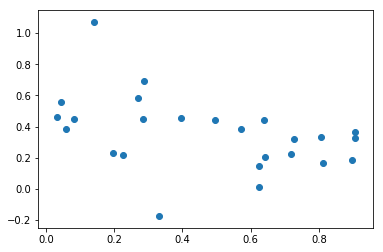

In [27]:
# Some initial plot
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(X, y)
plt.show()

In [28]:
import tensorflow as tf
tf.__version__ # Should be '2.0.0-beta0'

'2.0.0-beta0'

In [29]:
# Cast the data to TF tensors
X = tf.constant(X)
y = tf.constant(y)

In [30]:
# Cast the data to tf.float32 for compatibility with default in tf.Variable
X = tf.cast(X, tf.float32)
y = tf.cast(y, tf.float32)

In [31]:
# Random initial guess for our linear regression parameters
west = tf.Variable(0.05)
best = tf.Variable(0.0)

In [32]:
def linear(xb):
    # Output of the linear model
    return xb * west + best

In [33]:
# Check it is returning predictions
linear(X)

<tf.Tensor: id=171, shape=(25,), dtype=float32, numpy=
array([0.00410321, 0.03124942, 0.0022194 , 0.02474734, 0.00160496,
       0.00289566, 0.0359645 , 0.0113263 , 0.04059012, 0.01985775,
       0.04526726, 0.03207052, 0.01434694, 0.016639  , 0.01427351,
       0.04524369, 0.02859161, 0.00987695, 0.04489909, 0.03126319,
       0.03199722, 0.00705291, 0.01356084, 0.03629699, 0.04029265],
      dtype=float32)>

In [34]:
# We will use this to save loss evolution and w's gradient throughout iterations
all_losses = []
all_grads = []

In [35]:
for i in range(1000):
    
    with tf.GradientTape() as tape:
    
        # Compute the output of the model
        ypred = linear(X)
    
        # Compute the error of the model
        l = tf.reduce_mean((ypred - y)**2)
        all_losses.append(l.numpy())
    
    # Compute the gradients of the error
    g = tape.gradient(l, [west, best])
    all_grads.append(g[0].numpy())
    
    # Optimize the parameters using the gradients
    west.assign_add(- 0.01 * g[0])
    best.assign_add(- 0.01 * g[1])

W0610 11:14:54.498608 15036 deprecation.py:323] From C:\Users\Simone\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


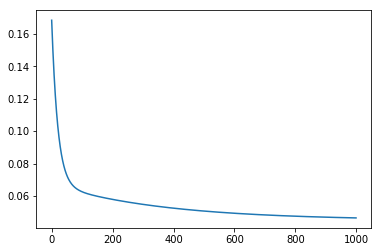

In [36]:
# Plot the loss
plt.figure()
plt.plot(all_losses)

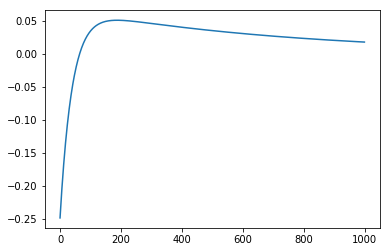

In [37]:
# Plot the gradients of w
plt.figure()
plt.plot(all_grads)

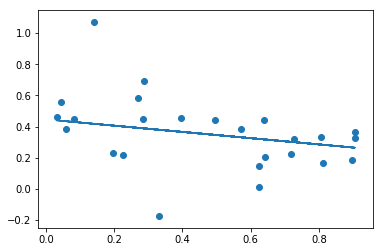

In [38]:
# Plot the final predictions
plt.figure()
plt.scatter(X, y)
plt.plot(X, linear(X))

In [39]:
# Check the values of the parameters
print(west)
print(best)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.20068194>
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.446361>
